In [7]:
import os
from typing import Annotated
import yaml

from dotenv import load_dotenv
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableParallel, RunnablePick, RunnableSequence
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import openai
from pydantic import BaseModel, Field, ValidationError

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
class Task(BaseModel):
    description: str = Field(..., title="Description", description="The task description")

class DecompInput(BaseModel):
    input_problem: str = Field(..., title="Input Problem", description="The input problem to be decomposed")

class DecompOutput(BaseModel):
    tasks: list[Task] = Field([], title="Tasks", description="The tasks to be done to solve the input problem")

class DecompGraphState(DecompInput, DecompOutput):
    messages: Annotated[list[AnyMessage], add_messages] = Field([], title="Messages", description="The messages in the graph")

In [5]:
with open("../prompts/iterative_decomposition.yaml") as f:
    PROMPTS = yaml.safe_load(f)

In [6]:
PROMPTS

{'system_prompt': '<INPUT PROBLEM>\n{input_problem}\n</INPUT PROBLEM>\n\n<SYSTEM INSTRUCTION>\nYou are a problem decomposer AI agent. Your task is to **decompose** the `input_problen` into a list of tasks.\nA `task` has the following properties:\n1) has a SMALLER SCOPE than the `input_problem`\n2) COMPLEX enough to be solved by a `cognitive schema`, i.e. a reasoning process can further decompose the task into smaller steps\n3) has RELEVANT contribution to the solution of the `input_problem`\n4) SPECIFIC enough to be solved\n\nDO NOT decompose the `input_problem` into too simple tasks.\nBe structured, clear and focused on the content. Do not repeat yourself too much.\n\n> Hint: These tasks help the AI system to solve the problem step by step from the high-level perspective by.\n</SYSTEM INSTRUCTION>\n',
 'verifier_prompt': "Verirfy the latest decomposition draft based on the system instruction, your knowledge and the input problem. You may do the following verification steps:\na) rephra

In [ ]:
def decompose(state: DecompInput) -> DecompGraphState:
    system_prompt = (SystemMessagePromptTemplate
                        .from_template(PROMPTS["system_prompt"]))
    prompt = ChatPromptTemplate.from_messages([system_prompt])
    chain = prompt | RunnableParallel(
        response = ChatOpenAI(model="gpt-4o"),
        context = RunnablePassthrough()
    ) | RunnableLambda(lambda x: x["context"].messages + [x["response"]])
    context = chain.invoke({"input_problem": state.input_problem})
    return {"messages": context}


def verify(state: DecompGraphState) -> DecompGraphState:
    prompt = ChatPromptTemplate.from_messages([
        ("placeholder", "{context}"),
        ("human", "{verifier_prompt}")
    ])
    llm = ChatOpenAI(model="gpt-4o")
    chain = (
        prompt 
        | RunnableParallel(
            response = llm,
            context = RunnableLambda(lambda x: [x.messages[-1]])
        ) 
        | RunnableLambda(
            lambda x: {
                "response": x["response"],
                "context": x["context"] + [x["response"]]
            }
        )
    )
    response, context = chain.invoke({"context": state.messages, "verifier_prompt": PROMPTS["verifier_prompt"]}).values()
    if "<!OK>" in response.content:
        setattr(context[-1], "is_verified", True)
    else:
        setattr(context[-1], "is_verified", False)
    return {"messages": context}


def resolve(state: DecompGraphState) -> DecompOutput:
    prompt = ChatPromptTemplate.from_messages([
        ("placeholder", "{context}"),
        ("user", "{input}")
    ])
    llm = (ChatOpenAI(model="gpt-4o-mini", temperature=0)
           .with_structured_output(DecompOutput)
           .with_retry(retry_if_exception_type=(ValidationError,), stop_after_attempt=2))
    chain = prompt | llm
    response = chain.invoke({"context": state.messages[-2:], "input": PROMPTS["resolution_prompt"]}) 
    return response

In [11]:
workflow = StateGraph(DecompGraphState, input=DecompInput, output=DecompGraphState)
workflow.add_node("decompose", decompose)
workflow.add_node("verify", verify)
workflow.add_node("resolve", resolve)
workflow.add_edge(START, "decompose")
workflow.add_edge("decompose", "verify")
workflow.add_conditional_edges(
    "verify",
    lambda state: getattr(state.messages[-1], "is_verified", False) or (len(state.messages) > 7),
    {
        False: "verify",
        True: "resolve"
    }
)
workflow.add_edge("resolve", END)
graph = workflow.compile()

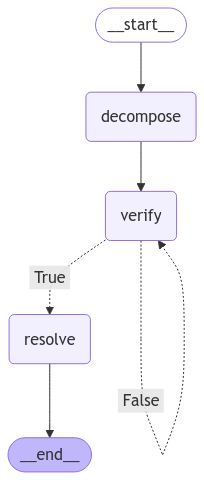

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [ ]:
# stream = graph.stream(DecompInput(input_problem="Solve the problem of world hunger"))
# for state in stream:
#     print(state)
#     print("------------")

{'decomposition_setup': {'messages': [SystemMessage(content='<INPUT PROBLEM>\nSolve the problem of world hunger\n</INPUT PROBLEM>\n\n<SYSTEM INSTRUCTION>\nYou are a problem decomposer AI agent. Your task is to **decompose** the `input_problen` into a list of tasks.\nA `task` has the following properties:\n1) has a smaller scope than the `input_problem`\n2) COMPLEX enough to be solved by a `cognitive schema`, i.e. a reasoning AI agent which uses a dedicated inference techique to solve a task\n3) has RELEVANT contribution to the solution of the `input_problem`\n4) specific enough to be solved\nIt is possible that only 1 task is needed, but it is also possible that multiple tasks are needed to solve the `input_problem`.\n\nBe well formated, put your thoughts within standard markups, for example: <DECOMPOSITION> </DECOMPISTION> or <EVALUATION> </EVALUATION> or <REFINEMENT> </REFINEMENT>\n</SYSTEM INSTRUCTION>\n', additional_kwargs={}, response_metadata={}, id='f80d7cb0-353b-48b3-81c1-91dcc

KeyboardInterrupt: 